[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franckalbinet/mirzai/blob/main/nbs/15_paper.cnn.learning_curve.ipynb)

# 4.2. Learning curve (CNN)

> Computing the learning curve of the CNN for the prediction of exchangeable potassium (K ex.), with increasing number of training examples and using all Soil Taxonomy Orders. 

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 10.8 MB/s 
     |████████████████████████████████| 1.4 MB 70.4 MB/s 
     |████████████████████████████████| 957 kB 68.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# Python utils
import math
from collections import OrderedDict
from tqdm.auto import tqdm
from pathlib import Path
from functools import partial
import pickle
import glob

# mirzai utilities
from mirzai.data.loading import load_kssl
from mirzai.data.selection import (select_y, select_tax_order, select_X)
from mirzai.data.transform import log_transform_y
from mirzai.training.cnn import (Model, weights_init)
from mirzai.data.torch import DataLoaders, SNV_transform
from mirzai.training.cnn import Learner
from mirzai.training.core import is_plateau
from mirzai.training.metrics import eval_reg

from fastcore.transform import compose

# Data science stack
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Deep Learning stack
import torch
from torch.nn import MSELoss
from torch.optim import Adam
from torch.optim.lr_scheduler import CyclicLR

import warnings
warnings.filterwarnings('ignore')

## Load and transform

In [ ]:
src_dir = '/content/drive/MyDrive/research/predict-k-mirs-dl/data/potassium'
fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
          'depth-order.npy', 'target.npy', 
          'tax-order-lu.pkl', 'spectra-id.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)

data = X, y, X_id, depth_order

transforms = [select_y, select_tax_order, select_X, log_transform_y]
X, y, X_id, depth_order = compose(*transforms)(data)

In [ ]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Wavenumbers:\n {X_names}')
print(f'depth_order (first 3 rows):\n {depth_order[:3, :]}')
print(f'Taxonomic order lookup:\n {tax_lookup}')

X shape: (40132, 1764)
y shape: (40132,)
Wavenumbers:
 [3999 3997 3995 ...  603  601  599]
depth_order (first 3 rows):
 [[43.  2.]
 [ 0.  0.]
 [ 0.  1.]]
Taxonomic order lookup:
 {'alfisols': 0, 'mollisols': 1, 'inceptisols': 2, 'entisols': 3, 'spodosols': 4, 'undefined': 5, 'ultisols': 6, 'andisols': 7, 'histosols': 8, 'oxisols': 9, 'vertisols': 10, 'aridisols': 11, 'gelisols': 12}


## Experiment

### Setup

In [ ]:
# Is a GPU available?
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'Runtime is: {device}')

n_epochs = 151
step_size_up = 5
criterion = MSELoss() # Mean Squared Error loss
base_lr, max_lr = 3e-5, 1e-3 # Based on learning rate finder
delta = 1e-3 # Loss difference threshold for early stopping

dest_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/learning_curve')

Runtime is: cuda:0


In [ ]:
training_size = [500, 1000, 2000, 5000, 10000, 20000, 30000, X.shape[0]]
split_ratio = 0.1
seeds = range(20)

In [ ]:
for seed in tqdm(seeds):
    perfs_by_size = OrderedDict({'seed': [], 'n_samples': [], 'test_score': [], 'n_epochs': []})
    
    for size in training_size:
        print(80*'-')
        print(f'Seed: {seed} | Size: {size}')
        print(80*'-')
        idx = np.random.choice(len(X), size, replace=False)
        
        # Train/test split
        data = train_test_split(X[idx, :], 
                                y[idx], 
                                depth_order[idx,1], 
                                test_size=split_ratio,
                                random_state=seed)
        X_train, X_test, y_train, y_test, tax_order_train, tax_order_test = data
        data_test = X_test, y_test, tax_order_test

        # Further train/valid split
        data = train_test_split(X_train, 
                                y_train,
                                tax_order_train,
                                test_size=split_ratio, 
                                random_state=seed)
        X_train, X_valid, y_train, y_valid, tax_order_train, tax_order_valid = data
        data_train = X_train, y_train, tax_order_train
        data_valid = X_valid, y_valid, tax_order_valid
        
        dls = DataLoaders(data_train, 
                          data_valid,
                          data_test,
                          transform=SNV_transform(),
                          batch_size=32)

        training_generator, validation_generator, test_generator = dls.loaders()
        
        # Modeling
        model = Model(X.shape[1], out_channel=16).to(device)
        opt = Adam(model.parameters(), lr=1e-4)
        model = model.apply(weights_init)
        scheduler = CyclicLR(opt, base_lr=base_lr, max_lr=max_lr,
                             step_size_up=step_size_up, mode='triangular',
                             cycle_momentum=False)

        early_stopper = partial(is_plateau, delta=delta, verbose=False)

        learner = Learner(model, criterion, opt, n_epochs=n_epochs, 
                          scheduler=scheduler, early_stopper=early_stopper,
                          tax_lookup=tax_lookup.values(), verbose=True)
        model, losses = learner.fit(training_generator, validation_generator)

        y_hat, y_true = learner.predict(test_generator)
        perfs = eval_reg(y_true, y_hat)

        perfs_by_size['seed'].append(seed)
        perfs_by_size['n_samples'].append(size)
        perfs_by_size['n_epochs'].append(len(losses['train']))
        perfs_by_size['test_score'].append(perfs['r2'])

    with open(dest_dir/f'cnn-lc-seed-{seed}.pickle', 'wb') as f: 
        pickle.dump(perfs_by_size, f)

  0%|          | 0/14 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
------------------------------
Epoch: 6
Training loss: 0.06806543636222093 | Validation loss: 0.0665476806461811
Validation loss (ends of cycles): [0.29326259]
------------------------------
Epoch: 7
Training loss: 0.06351911573793878 | Validation loss: 0.06200351657574637
Validation loss (ends of cycles): [0.29326259]
------------------------------
Epoch: 8
Training loss: 0.05975192000159968 | Validation loss: 0.05620013448622143
Validation loss (ends of cycles): [0.29326259]
------------------------------
Epoch: 9
Training loss: 0.05616931922190053 | Validation loss: 0.053450687412630045
Validation loss (ends of cycles): [0.29326259]
------------------------------
Epoch: 10
Training loss: 0.05372029852261675 | Validation loss: 0.05114826099260857
Validation loss (ends of cycles): [0.29326259 0.05114826]
------------------------------
Epoch: 11
Training loss: 0.054583898482796475 | Validation loss: 0.05386886536552195
Validation loss 

In [ ]:
def load_all(src_dir):
    dumps = []
    for file in glob.glob(str(src_dir/'*.pickle')):
        with open(file, 'rb') as f: 
            dumps.append(pickle.load(f))
    return dumps

In [ ]:
src_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/learning_curve')
dumps = load_all(src_dir)

In [ ]:
df = pd.concat([pd.DataFrame(perf) for perf in dumps])
grps = df.groupby(['n_samples']).agg({'test_score':['mean','std'], 'n_epochs':['mean','std']})
grps.head()

test_score              n_epochs           
                mean       std        mean        std
n_samples                                            
500         0.413549  0.184284  111.000000  47.749346
1000        0.453063  0.073105   79.333333  17.224014
2000        0.534975  0.051113  121.000000  33.466401
5000        0.607885  0.039500   87.666667  23.380904
10000       0.677188  0.020144  101.000000  28.284271

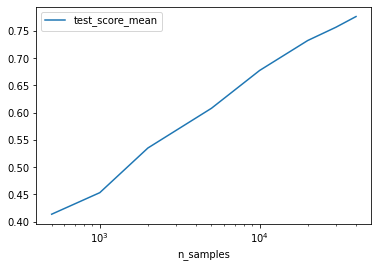

In [ ]:
grps.columns = grps.columns.map('_'.join)
grps.reset_index().plot(x='n_samples', y='test_score_mean', logx=True);

### Save results

In [ ]:
dest_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps')

with open(dest_dir/'cnn_test_perf_vs_n_samples.pickle', 'wb') as f: 
    pickle.dump(grps, f)